<a href="https://colab.research.google.com/github/dtnam302/CV/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV

/content/drive/MyDrive/Colab Notebooks/CV


## **1. Download data**

In [ ]:
!gdown --id 1wETEA_jrNzDsSS2NcmOI6yI123kNt1Km

Downloading...
From: https://drive.google.com/uc?id=1wETEA_jrNzDsSS2NcmOI6yI123kNt1Km
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 46.9kB/s]


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=3967160bae5a449101b42cfcba7b4b6675ce69d8ab3ed619ebcaf9e312bd3a7e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 604M/612M [00:04<00:00, 156MB/s]
100% 612M/612M [00:04<00:00, 141MB/s]


In [ ]:
!unzip /content/gtsrb-german-traffic-sign.zip -d '/content/drive/MyDrive/Colab Notebooks/CV/data'

In [ ]:
import urllib.request

print('Beginning file download...')

url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'

urllib.request.urlretrieve(url, './traffic-signs-data.zip')

Beginning file download...


('./traffic-signs-data.zip', <http.client.HTTPMessage at 0x7f08777bfbd0>)

In [ ]:
import zipfile
import os


print('Beginning file unzip')

zip_ref = zipfile.ZipFile('./traffic-signs-data.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/CV/data')
zip_ref.close()

print('Done')


Beginning file unzip
Done


## **2. Import Lib and Constant define**

In [ ]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import glob
import shutil

%matplotlib inline
import tensorflow as tf
#import prettytensor as pt
from PIL import Image
import time
from datetime import timedelta
from sklearn.metrics import confusion_matrix
from skimage.io import imshow,imread


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/CV/data/"
RP_PATH = "/content/drive/MyDrive/Colab Notebooks/CV/report/"
TEST_PATH = DATA_PATH + "Test.csv"
TRAIN_PATH = DATA_PATH + "Train.csv"
GROUND_TRUTH = DATA_PATH + "Meta.csv"
SIGN_NAME = DATA_PATH + "signnames.csv"

## **3. Exploding data**

### Read data from csv file

In [ ]:
def load_image(file_path):
    path = os.path.join(DATA_PATH, file_path)
    image = imread(path)
    return image

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [ ]:
print(train_data.head())
len(train_data),len(test_data)

   Width  Height  Roi.X1  ...  Roi.Y2  ClassId                            Path
0     27      26       5  ...      20       20  Train/20/00020_00000_00000.png
1     28      27       5  ...      22       20  Train/20/00020_00000_00001.png
2     29      26       6  ...      21       20  Train/20/00020_00000_00002.png
3     28      27       5  ...      22       20  Train/20/00020_00000_00003.png
4     28      26       5  ...      21       20  Train/20/00020_00000_00004.png

[5 rows x 8 columns]


(39209, 12630)

In [ ]:
def clean_path(df,train=True):
  clean_df = pd.DataFrame.copy(df)
  for idx,ele in enumerate(clean_df['Path']):
    if train:
      clean_df['Path'][idx] = ele.replace('Train/','')
    else:
      clean_df['Path'][idx] = ele.replace('Test/','')
  clean_df['ClassId'] = clean_df['ClassId'].astype(str)
  return clean_df
  


In [ ]:
train_data_gen = clean_path(train_data)
test_data_gen = clean_path(test_data,train=False)
test_data_gen.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,00000.png
1,42,45,5,5,36,40,1,00001.png
2,48,52,6,6,43,47,38,00002.png
3,27,29,5,5,22,24,33,00003.png
4,60,57,5,5,55,52,11,00004.png


### Ground truth for visualization 

In [ ]:
ground_truths = pd.read_csv(GROUND_TRUTH)
sign_names = pd.read_csv(SIGN_NAME)

In [ ]:
def read_ground_truth(g_df,s_df):
  g_imgs = []
  g_labels = []
  for id in s_df['ClassId']:
    row = g_df[g_df['ClassId'] == id]
    g_imgs.append(row['Path'].to_string().split(' ')[-1])
    g_labels.append(s_df['SignName'][id])
  return g_imgs,g_labels


In [ ]:
g_imgs,g_labels = read_ground_truth(ground_truths,sign_names)

In [ ]:
g_imgs[0]

'Meta/0.png'

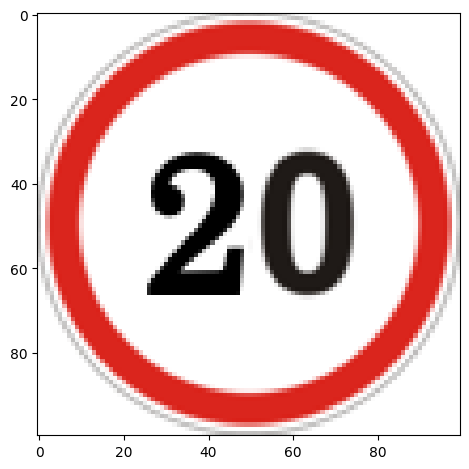

In [ ]:
imshow(load_image(g_imgs[0]))

In [ ]:
g_labels[0]

'Speed limit (20km/h)'

###Visualization of Dataset

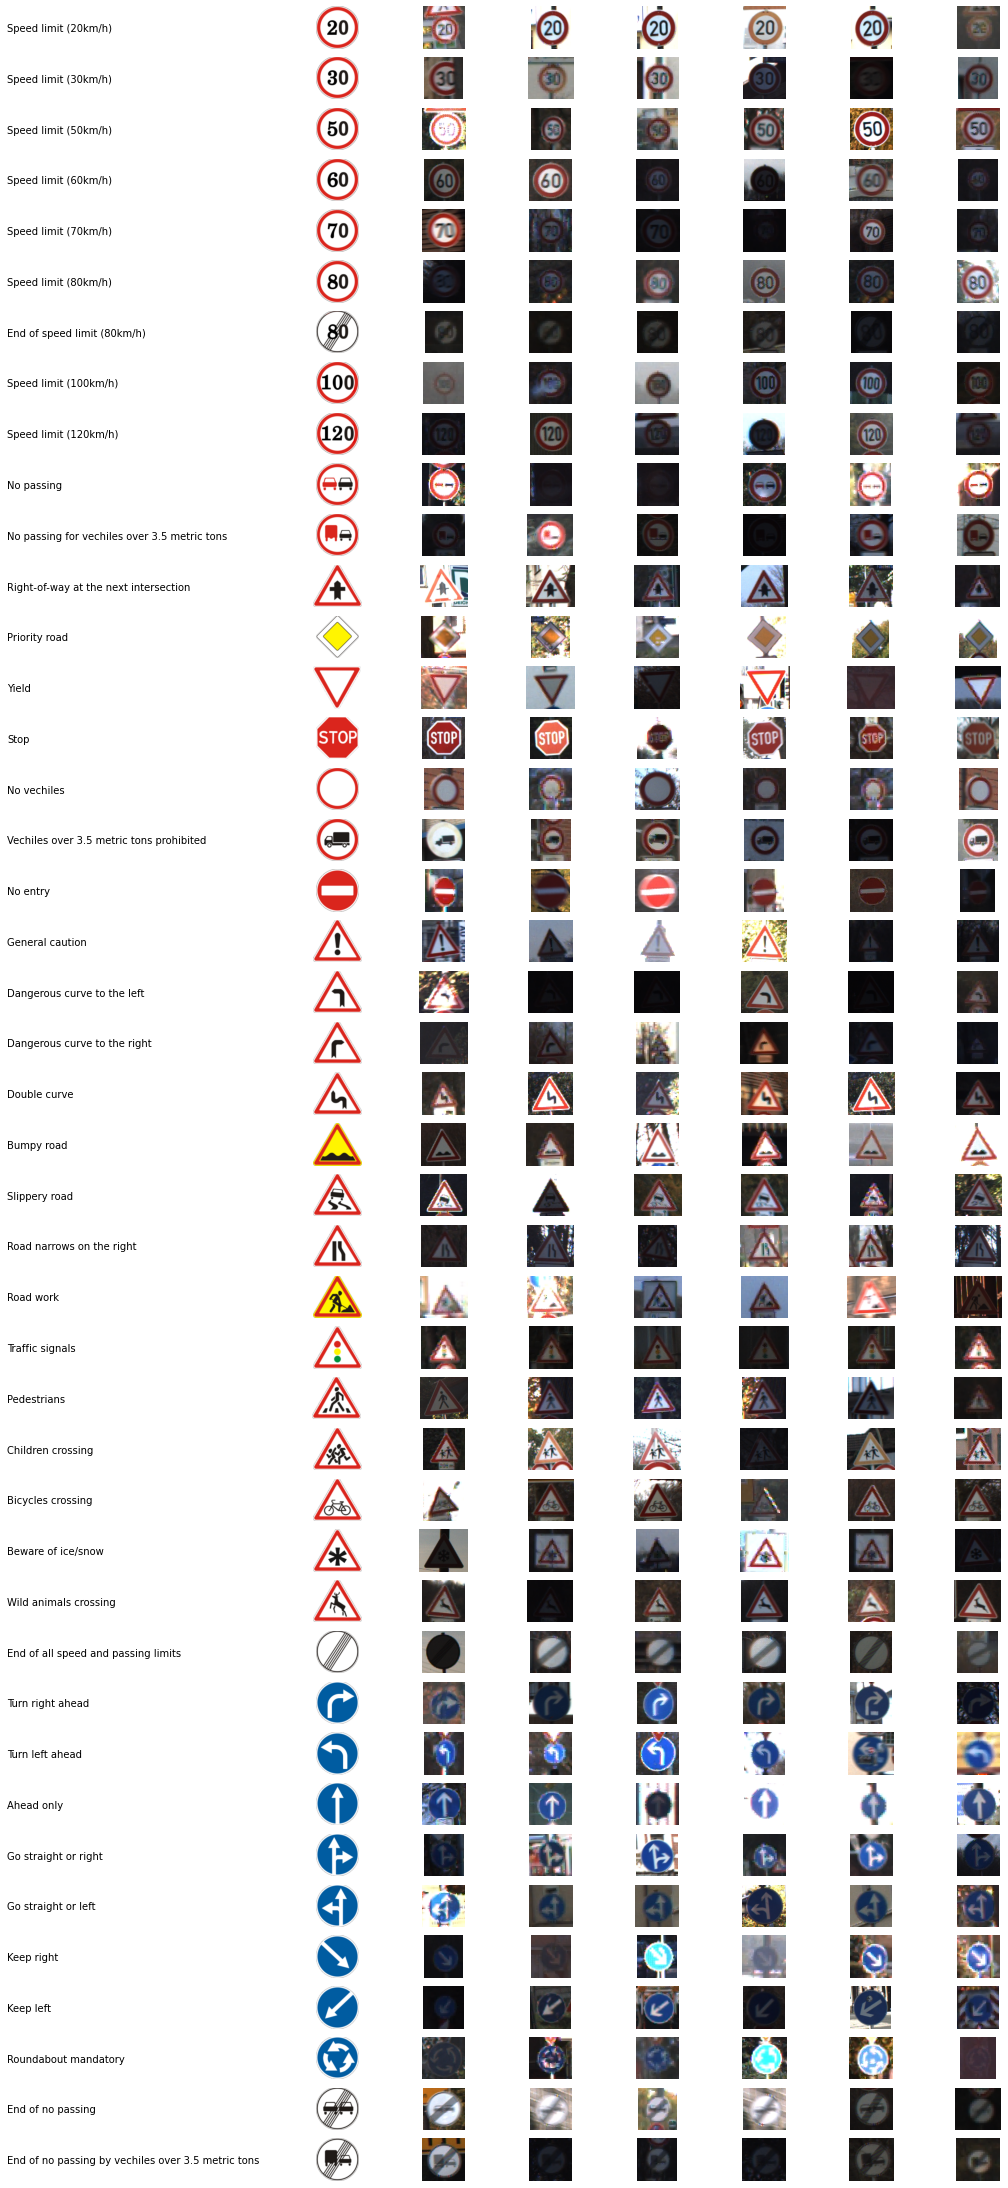

In [ ]:
n_classes = len(g_labels)
gs = gridspec.GridSpec(n_classes, 8) # 1 for text ground truth, 1 for image ground truth, 6 samples

#data_index = [np.where(np.array(y_train)==classid)[0] for classid in range(n_classes)]
# plot samples for each traffic signs 
data_set_fig = plt.figure(num=1,figsize=(15, 40))
# st = data_set_fig.suptitle("Training  DataSet Samples", fontsize="x-large")
ax = []
for class_id in range(n_classes):
    # plot ground truth label
    ax.append(data_set_fig.add_subplot(gs[class_id, 0]))
    ax[-1].text(-2, 0.6, g_labels[class_id], ha='left', va='top', wrap=True)
    ax[-1].set_axis_off()
    
    # plot ground truth image
    ax.append(data_set_fig.add_subplot(gs[class_id, 1]))
    ax[-1].imshow(load_image(g_imgs[class_id]))
    ax[-1].set_axis_off()
    # plot random samples for each class
    train_class = train_data[train_data['ClassId'] == class_id]
    samples = train_class.sample(n=6,random_state = 302)
    for idx,sample in enumerate(samples['Path']):
        image = load_image(sample)
        ax.append(data_set_fig.add_subplot(gs[class_id, idx+2]))
        ax[-1].imshow(image)
        ax[-1].set_axis_off()

###Plot Distribution

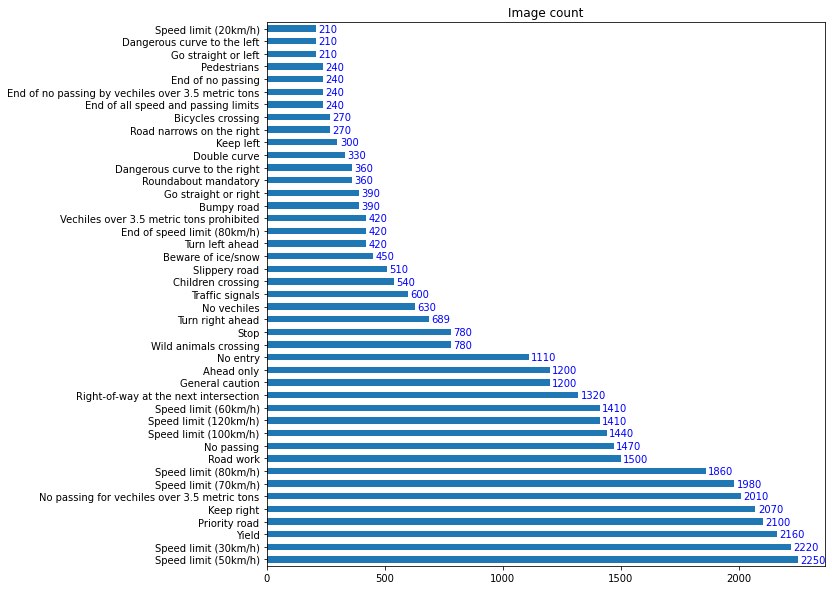

In [ ]:
def plot_histogram(train_data,label):
    ax = train_data[label].value_counts().plot(kind='barh', figsize = (10,10), title='Image count')
    ax.set_yticklabels(list(map(lambda x: g_labels[x], train_data[label].value_counts().index.tolist()))) 

    for i, v in enumerate(train_data[label].value_counts()):
        ax.text(v + 10, i - 0.25, str(v), color='blue')
plot_histogram(train_data,'ClassId')

## **4. Preprocessing Data**

###Pickle data

In [ ]:
# Load pickled data
import pickle

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
#Number of training examples
n_train = y_train.shape[0]

#Number of validation examples
n_validation = y_valid.shape[0]

#Number of testing examples.
n_test = y_test.shape[0]

#Traffic Sign Image shape
image_shape = X_train[0].shape

#Number of unique classes
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

###My augumentation


In [ ]:
from collections import Counter
from tqdm import tqdm
import random

In [ ]:
#Declare augmentation functions

#References: 
#https://github.com/vxy10/ImageAugmentation 
#https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification
#        -using-6355346da2dc
#https://navoshta.com/traffic-signs-classification/
#https://github.com/vxy10/ImageAugmentation


def transform_image(img, rt_range, xlate_range):
    #Define Transformations - rotation and translation
    pixels_x, pixels_y, channels = img.shape    
    rt_angle = np.random.uniform(rt_range) - rt_range/2
    xlate_x = np.random.uniform(xlate_range) - xlate_range/2
    xlate_y = np.random.uniform(xlate_range) - xlate_range/2
    
    M_rot = cv2.getRotationMatrix2D((pixels_y/2, pixels_x/2), rt_angle, 1)
    M_xlate = np.float32([[1,0,xlate_x],[0,1,xlate_y]])
    
    #Transform image
    img = cv2.warpAffine(img, M_xlate, (pixels_y, pixels_x))
    img = cv2.warpAffine(img, M_rot, (pixels_y, pixels_x))
    
    return img

def augment_set(X_data, y_data, labels, threshold, rt_range, xlate_range):
    
    #Declare all variables
    images_dict = {}
    n_imgs = 0 #total # of images that will be perturbed
    pixels_x, pixels_y, channels = X_data.shape[1:4]
    n_aug_imgs = {} #holds # of images that need to be created for each label
    
    #Determine indices of images that need to be augmented and their corresponding labels
    for label in labels:
        images_dict[label] = X_data[np.where(y_data == label)]
        n_aug_imgs[label] =  threshold - images_dict[label].shape[0]
        n_imgs += images_dict[label].shape[0]
        
    #Determine how many perturbed images need to be created for each label to meet the threshold
    print ("# of images available to be perturbed:", n_imgs)
    print("# of images to be created per label", n_aug_imgs)
    print("Total # of images to be created:", sum(n_aug_imgs.values()))
    
    #Create empty array to hold perturbed images
    new_images = np.empty([sum(n_aug_imgs.values()), pixels_x, pixels_y, channels], dtype = np.uint8)
    new_labels = np.empty([sum(n_aug_imgs.values())], dtype = int)
    #print("The shapes of the new arrays are:", new_images.shape, new_labels.shape)
    
    #Loop through labels/image arrays, determine # of perturbations for each image in label then perturb image
    offset = 0
    for label, img_array in tqdm(images_dict.items(), total = len(labels)):
        #print("The image counter has been reset, starting label", label)
        new_img_count = 0
        n_pertubations = math.ceil(n_aug_imgs[label]/images_dict[label].shape[0])
        #print("Labels {:d} has {:d} images and {:d} new images need to be created"
              #.format(label, images_dict[label].shape[0], n_aug_imgs[label]))
        for img_index, img in enumerate(img_array):
            #print("We will create {:d} pertubations for this image.".format(n_pertubations))
                
            #create the desired number of pertubations
            for i in range(n_pertubations):
                #Create the new image and label
                new_images[i+img_index*n_pertubations+offset] = transform_image(img, rt_range, xlate_range)
                #print("The new label is", label, "at index", i+img_index*n_pertubations+offset)
                new_labels[i+img_index*n_pertubations+offset] = label
                new_img_count += 1
                
                if (new_img_count == n_aug_imgs[label]):
                    break
            
            if (new_img_count == n_aug_imgs[label]):
                break
        
        offset += n_aug_imgs[label]
        #print("{:d} new images created for label {:d}".format(new_img_count, label))
        #print("The offset is now {:d}\n".format(offset))
        
        aug_X_data = np.concatenate((X_data, new_images), 0)
        aug_y_data = np.concatenate((y_data, new_labels), 0)


    return (aug_X_data, aug_y_data) 

#Do image mirroring and rotations on labels that are invariant to the operation
def basic_augment(X_data, y_data, xflip, yflip, rot120):    
   
    #Define variables and dictionaries
    xflip_dict = {}
    yflip_dict = {}
    rot_dict = {}
    n_xflip_imgs, n_yflip_imgs, n_rot_imgs = 0, 0, 0
    
    #Setup up rotation matrices
    pixels_x, pixels_y, channels = X_data.shape[1:4]
    M1 = cv2.getRotationMatrix2D((pixels_y/2,pixels_x/2), 120, 1)
    M2 = cv2.getRotationMatrix2D((pixels_y/2,pixels_x/2), 240, 1)
    
    #Populate dictonary with images to be operated on with key = label
    for old_label, new_label in xflip:
        xflip_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_xflip_imgs += xflip_dict[old_label].shape[0]
    
    for old_label, new_label in yflip:
        yflip_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_yflip_imgs += yflip_dict[old_label].shape[0]
  
    for old_label, new_label in rot120:
        rot_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_rot_imgs += rot_dict[old_label].shape[0]
    
    #Create empty arrays to hold new images and their corresponding labels
    xflip_images = np.empty([n_xflip_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    xflip_labels = np.empty([n_xflip_imgs], dtype = int)
    yflip_images = np.empty([n_yflip_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    yflip_labels = np.empty([n_yflip_imgs], dtype = int)
    rot_images = np.empty([2*n_rot_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    rot_labels = np.empty([2*n_rot_imgs], dtype = int)

    #Perform xflips, yflips and 120deg, 240deg rotations
    offset = 0
    for label, img_array in xflip_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                xflip_images[index+offset] = cv2.flip(img,0)
                xflip_labels[index+offset] = label
            offset += img_array.shape[0]
    
    offset = 0
    for label, img_array in yflip_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                yflip_images[index+offset] = cv2.flip(img,1)
                yflip_labels[index+offset] = yflip[np.where(yflip[:,0] == label),1][0][0]
            offset += img_array.shape[0]
    
    offset = 0
    for label, img_array in rot_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                rot_images[index+offset] = cv2.warpAffine(img, M1, (pixels_y,pixels_x))
                rot_images[index+n_rot_imgs+offset] = cv2.warpAffine(img, M2, (pixels_y,pixels_x))
                rot_labels[index+offset] = label
                rot_labels[index+n_rot_imgs+offset] = label
            offset += img_array.shape[0]
    
    #Append arrays and return new training data set
    
    aug_X_data = np.concatenate((X_data, xflip_images, yflip_images, rot_images), 0)
    aug_y_data = np.concatenate((y_data, xflip_labels, yflip_labels, rot_labels), 0)
    print("Number of x-flipped images:", xflip_images.shape[0])
    print("Number of y-flipped images:", yflip_images.shape[0])
    print("Number of rotated images (2x the input):", rot_images.shape[0])
    print("Total # of appended images:", xflip_images.shape[0] + yflip_images.shape[0] + rot_images.shape[0])
    print("Original training data set had {:d} images".format(X_data.shape[0]))
    print("Augmented training data set has {:d} images\n".format(aug_X_data.shape[0]))
        
    return (aug_X_data, aug_y_data)

Number of x-flipped images: 990
Number of y-flipped images: 5069
Number of rotated images (2x the input): 600
Total # of appended images: 6659
Original training data set had 34799 images
Augmented training data set has 41458 images

Lets visualize the new augmented data set. Some of the lables have been augmented but clearly, more augmentation is required:


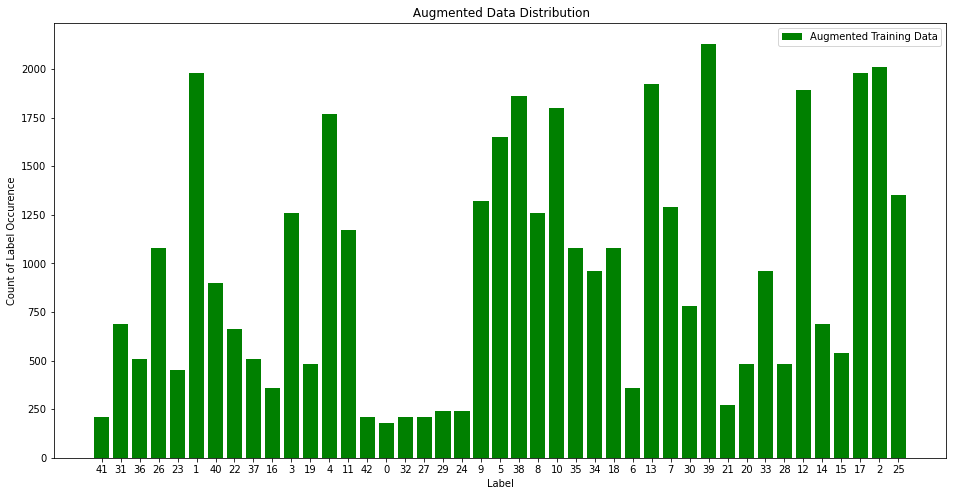

The following 33 labels have less than 1500 training samples and need to be augmented:

[41, 31, 36, 26, 23, 40, 22, 37, 16, 3, 19, 11, 42, 0, 32, 27, 29, 24, 9, 8, 35, 34, 18, 6, 7, 30, 21, 20, 33, 28, 14, 15, 25]
# of images available to be perturbed: 22468
# of images to be created per label {41: 1290, 31: 810, 36: 990, 26: 420, 23: 1050, 40: 600, 22: 840, 37: 990, 16: 1140, 3: 240, 19: 1020, 11: 330, 42: 1290, 0: 1320, 32: 1290, 27: 1290, 29: 1260, 24: 1260, 9: 180, 8: 240, 35: 420, 34: 541, 18: 420, 6: 1140, 7: 210, 30: 720, 21: 1230, 20: 1020, 33: 541, 28: 1020, 14: 810, 15: 960, 25: 150}
Total # of images to be created: 27032


100%|██████████| 33/33 [00:02<00:00, 12.97it/s]

The final augmented training set has 68490 images


In [ ]:
#Do Preliminary Augmentation on Dataset (i.e. image mirroring and simple rotations)

#Identify which labels can be flipped horizontally/vertically and determine the new label if changed [oldlabel, new label].
#This is not an exhaustive list since not all labels that can be flipped require augmentation

labels_x_flip = np.array([[17,17]])
labels_y_flip = np.array([[19,20], [20,19], [22,22], [26,26], [30,30], [33,34], [34,33], [36,37], [37,36], [38,39]])
labels_rot_120 = np.array([[40,40]])

X_train_aug, y_train_aug = basic_augment(X_train, y_train, labels_x_flip, labels_y_flip, labels_rot_120)

print("Lets visualize the new augmented data set. Some of the lables have been augmented but" 
      " clearly, more augmentation is required:")

#Plot histogram of labels in each set
aug_train_set = Counter(y_train_aug)
valid_set = Counter(y_valid)
test_set = Counter(y_test)

plt.figure(figsize=(16,8))
plt.title(' Augmented Data Distribution')
aug_train_bar = plt.bar(range(len(aug_train_set)), aug_train_set.values(), color = 'g')

plt.xticks(range(len(aug_train_set)), aug_train_set.keys())
plt.xlabel('Label')
plt.ylabel('Count of Label Occurence')
plt.legend([aug_train_bar], ['Augmented Training Data'])
#plt.savefig('.\\graphics\\AugDataHistogram.png')
plt.show()

#Identify which labels need to be augmented
labels_to_augment = []
n_threshold = 1500
for key in aug_train_set.keys():
    if(aug_train_set[key] < n_threshold):
        labels_to_augment.append(key)
print("The following {:d} labels have less than {:d} training samples and need to be augmented:\n"
      .format(len(labels_to_augment), n_threshold))
print(labels_to_augment)

#Perform additional augmentation to get under-represented labels in the training set up to the threshold
rt_range = 15
xlate_range = 5
X_train_aug2, y_train_aug2 = augment_set(X_train_aug, y_train_aug, labels_to_augment, 
                                         n_threshold, rt_range, xlate_range)

print("The final augmented training set has {:d} images".format(X_train_aug2.shape[0]))

Let's plot that histogram again...


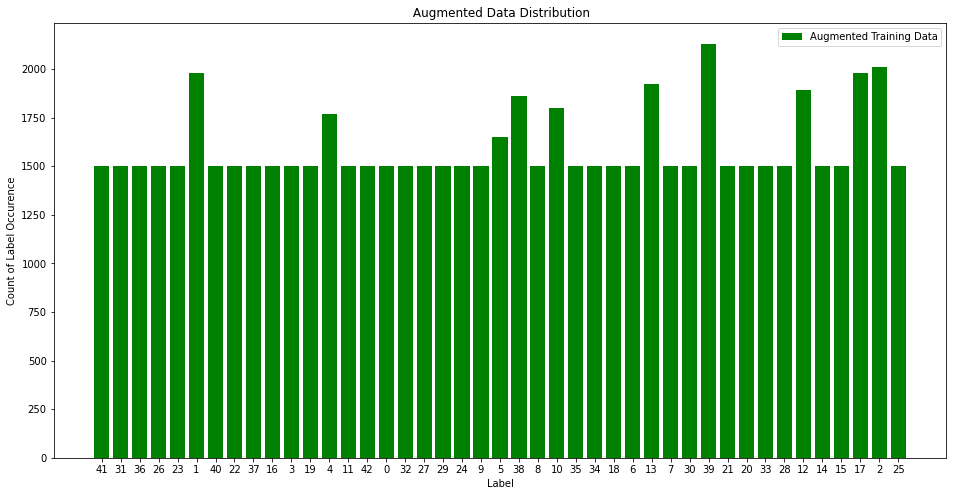

The data distribution is much more balanced. Let's take a look at some of the newly transformed images:


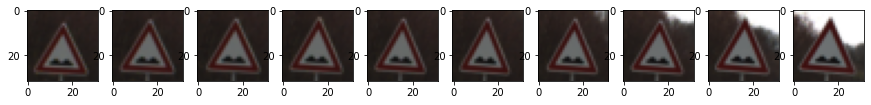

In [ ]:
print("Let's plot that histogram again...")

aug_train_set = Counter(y_train_aug2)


plt.figure(figsize=(16,8))
plt.title(' Augmented Data Distribution')
aug_train_bar = plt.bar(range(len(aug_train_set)), aug_train_set.values(), color = 'g')


plt.xticks(range(len(aug_train_set)), aug_train_set.keys())
plt.xlabel('Label')
plt.ylabel('Count of Label Occurence')
plt.legend([aug_train_bar], ['Augmented Training Data'])
#plt.savefig('.\\graphics\\FinalDataHistogram.png')
plt.show()

print("The data distribution is much more balanced. Let's take a look at some of the newly transformed images:")
index = random.randint(34799, len(X_train_aug2))
n_images = 10
image = X_train_aug2[index:index+n_images]
image_labels = y_train_aug2[index:index+n_images]
plt.figure(figsize=(15,3))
for i in range(n_images):
    plt.subplot(1,n_images,i+1)
    plt.imshow(image[i])
plt.savefig('.\\graphics\\augmentation.png')
plt.show()

In [ ]:
y_train_aug2 = tf.keras.utils.to_categorical(y_train_aug2, n_classes)
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test,n_classes)

In [ ]:
X_train_aug2.shape,y_train_aug2.shape

((68490, 32, 32, 3), (68490, 43))

In [ ]:
X_valid.shape,y_valid.shape

((4410, 32, 32, 3), (4410, 43))

###Image Datagenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    )
test_datagen = ImageDataGenerator(
    rescale=1./255.)

In [ ]:
val_generator = train_datagen.flow(
    x=X_valid, 
    y=y_valid, 
    batch_size=128, 
    shuffle=True
)

In [ ]:
test_generator = train_datagen.flow(
    x=X_test, 
    y=y_test, 
    batch_size=1, 
    shuffle=False,
)

Original data - imbalanced data

In [ ]:
train_generator = train_datagen.flow(
    x=X_train, 
    y=y_train, 
    batch_size=128, 
    shuffle=True
)

With data augumentation - 1st refactor

In [ ]:
if train_generator:
  train_generator.reset()
train_generator = train_datagen.flow(
    x=X_train_aug2, 
    y=y_train_aug2, 
    batch_size=128, 
    shuffle=True
)

###Visualize data aug

In [ ]:
viz_generator = train_datagen.flow(
    x=x_train, 
    y=y_train, 
    batch_size=1, 
    shuffle=True
)

rows=5
cols=5
imgs = []
for i in range(30):
  img, label = next(viz_generator)
  imgs.append(img[0])

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
for row in range(rows):
    for col in range(cols):
        if row*4 + col >= len(imgs): break
        ax[row, col].imshow(imgs[row*4 + col])

## **5. Define Model**

In [ ]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Flatten,Dense
from keras.layers.merge import concatenate

In [ ]:
!pip install stn

In [ ]:
from stn import spatial_transformer_network as transformer

In [ ]:
def localization_net(layer_in):

  conv1 = Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3))(layer_in)
  pool1 = MaxPooling2D(pool_size=(2, 2), padding='valid')(conv1)

  conv2 = Conv2D(filters=24, kernel_size=(5, 5), activation='relu')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2), padding='valid')(conv2)

  flat = Flatten()(pool2)

  fc1 = Dense(units=100, activation='tanh')(flat)

  drop = Dropout(0.4)(fc1)

  fc2 = Dense(units=6, activation = 'tanh')(drop)

  return fc2

In [ ]:
# example of creating a CNN with an efficient inception module

 
# function for creating a projected inception module
def inception_block(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu',strides=(3,3))(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(conv1)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(conv1)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv3)
	
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
 
	
	return layer_out

In [ ]:
# function for creating a projected inception module
def inception_block_v2(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [ ]:
def unified_inception_model(input,r1,r2,n_classes):
    
    
    ## Create a spatial transformer module
    affain_transformation = localization_net(input)
    x_trans = transformer(input, affain_transformation, (32, 32))
    #x_trans = input
    # inception Block #1
    
    inception_1 = inception_block(x_trans,24,16,8)
    
    # Dropout layer
    
    inception_dropout = Dropout(r1)(inception_1)
    
    # inception Block #2
    
    inception_2 = inception_block(inception_dropout,24,16,8)
    
    # Flatten layer
    
    flatten_features = Flatten(name = 'Sequential')(inception_2)
    
    # Fully connected layer 1.. Input = 1000. Output = 1000. 
    
    FC1 = Dense(512,activation='relu')(flatten_features)
    
    # Fully connected layer 2. Input = 512. Output = 1000.
    
    FC2 = Dense(100,activation='relu')(FC1)
    
    # Dropout for regularization
    
    FC2 = Dropout(r2)(FC2)
    
    # Fully connected layer3. Input = 100. Output = n_classes.
    logits = Dense(n_classes,activation='softmax')(FC2)
    
    model = Model(inputs=input, outputs=logits)
    
    return model

In [ ]:
def unified_inception_model_v2(input,r1,r2,n_classes):
    
    
    
    
    ## Create a spatial transformer module
    affain_transformation = localization_net(input)
    x_trans = transformer(input, affain_transformation, (32, 32))
    #x_trans = input
    # inception Block #1
    
    inception_1 = inception_block_v2(x_trans,64, 96, 128, 16, 32, 32)
    inception_1 = Dropout(0.4)(inception_1)
    inception_2 = inception_block_v2(inception_1,64, 96, 128, 16, 32, 32)
    
    # Flatten layer
    
    flatten_features = Flatten(name = 'Sequential')(inception_2)
    
    # Fully connected layer 1.. Input = 1000. Output = 1000. 
    
    FC1 = Dense(512,activation='relu')(flatten_features)
    
    # Fully connected layer 2. Input = 512. Output = 1000.
    
    FC2 = Dense(100,activation='relu')(FC1)
    
    # Dropout for regularization
    
    FC2 = Dropout(r2)(FC2)
    
    # Fully connected layer3. Input = 100. Output = n_classes.
    logits = Dense(n_classes,activation='softmax')(FC2)
    
    model = Model(inputs=input, outputs=logits)
    
    return model

## **6. Training Phase**

In [ ]:
keras.backend.clear_session()

###Get model

Original Model

In [ ]:
# define model input
visible = Input(shape=(32, 32, 3))

model = unified_inception_model(visible, 0.5,0.5,n_classes)

# summarize model
#model.summary()

My model

In [ ]:
# define model input
visible = Input(shape=(32, 32, 3))

model = unified_inception_model_v2(visible, 0.5,0.5,n_classes)

# summarize model
#model.summary()

###Define optimization, loss, metrics

In [ ]:
cb_es = tf.keras.callbacks.EarlyStopping( patience=7,
                                          monitor='val_loss', 
                                          min_delta=0.005,
                                          restore_best_weights=True)

In [ ]:
#adding callbacks
def get_ckpt(ckpt_path):
  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True)
  return checkpoint


In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

cb_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Original Model

In [ ]:
#no check point, no early stopping
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'],
              )

###Training

In [ ]:

history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=50, 
                    steps_per_epoch = train_generator.n//train_generator.batch_size, 
                    validation_steps = val_generator.n // val_generator.batch_size
                    )

Epoch 1/50
535/535 [==============================] - 34s 39ms/step - loss: 3.6100 - categorical_accuracy: 0.0468 - val_loss: 3.2764 - val_categorical_accuracy: 0.1193
Epoch 2/50
535/535 [==============================] - 21s 39ms/step - loss: 3.0447 - categorical_accuracy: 0.1591 - val_loss: 2.4644 - val_categorical_accuracy: 0.3311
Epoch 3/50
535/535 [==============================] - 21s 38ms/step - loss: 2.4064 - categorical_accuracy: 0.3155 - val_loss: 1.7653 - val_categorical_accuracy: 0.4602
Epoch 4/50
535/535 [==============================] - 23s 43ms/step - loss: 1.9535 - categorical_accuracy: 0.4267 - val_loss: 1.4373 - val_categorical_accuracy: 0.5253
Epoch 5/50
535/535 [==============================] - 23s 43ms/step - loss: 1.6602 - categorical_accuracy: 0.4959 - val_loss: 1.2352 - val_categorical_accuracy: 0.6151
Epoch 6/50
535/535 [==============================] - 21s 40ms/step - loss: 1.4431 - categorical_accuracy: 0.5535 - val_loss: 1.0775 - val_categorical_accuracy:

In [ ]:
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=30, 
                    steps_per_epoch = train_generator.n//train_generator.batch_size, 
                    validation_steps = val_generator.n // val_generator.batch_size,
                    callbacks = [cb_es]
                    )

Epoch 27/30
535/535 [==============================] - 185s 345ms/step - loss: 0.0174 - categorical_accuracy: 0.9949 - val_loss: 0.1859 - val_categorical_accuracy: 0.9651
Epoch 28/30
535/535 [==============================] - 185s 346ms/step - loss: 0.0183 - categorical_accuracy: 0.9945 - val_loss: 0.2218 - val_categorical_accuracy: 0.9612


In [ ]:
model.save(RP_PATH+'original_model/model.h5')
pickle.dump(history.history, open( RP_PATH+'original_model/history.p', "wb" ))

In [ ]:
model.save(RP_PATH+'my_model/model.h5')
pickle.dump(history.history, open( RP_PATH+'my_model/history.p', "wb" ))

In [ ]:
model.save(RP_PATH+'original_model/model_aug.h5')
pickle.dump(history.history, open( RP_PATH+'original_model/history_aug.p', "wb" ))

In [ ]:
model.save(RP_PATH+'my_model/model_aug.h5')
pickle.dump(history.history, open( RP_PATH+'my_model/history_aug.p', "wb" ))

## **7. Evaluating Phase**

###Define plot function

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
def plot_loss_accuracy(history):
    plt.style.use('fivethirtyeight')
    fig, axs = plt.subplots(1,2, figsize=(12, 5))

    hist = history

    for ax, metric in zip(axs, ["loss", "categorical_accuracy"]):
        ax.plot(hist[metric])
        ax.plot(hist["val_"+metric])
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)
    plt.style.use('default')

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:


"""
Ref : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def get_cf(y_test,y_pred_raw):
  #y_pred_raw = (y_pred_raw > 0.5) 
  y_pred_cf=np.argmax(y_pred_raw, axis=1)
  y_test_cf=np.argmax(y_test, axis=1)
  cf_matrix = confusion_matrix(y_test_cf, y_pred_cf)
  return cf_matrix

In [ ]:
def plot_infer(n_samples,X_test,y_test,y_pred_raw,get_true=True):
  y_conf = np.amax(y_pred_raw,axis=1)
  y_pred = np.argmax(y_pred_raw,axis=1)
  y_pred_gt = np.argmax(y_test,axis=1)
  if get_true:
    predictions = X_test[y_pred == y_pred_gt]
    predictions_cf = y_conf[y_pred == y_pred_gt]
    predictions_gt = y_pred_gt[y_pred == y_pred_gt]
    predictions_pred = y_pred[y_pred == y_pred_gt]
  else:
    predictions = X_test[y_pred != y_pred_gt]
    predictions_cf = y_conf[y_pred != y_pred_gt]
    predictions_gt = y_pred_gt[y_pred != y_pred_gt]
    predictions_pred = y_pred[y_pred != y_pred_gt]
  
  test_gs = gridspec.GridSpec(n_samples, 5)

  # plot samples for each traffic signs 
  data_set_fig = plt.figure(figsize=(15, 20))
  # st = data_set_fig.suptitle("Training  DataSet Samples", fontsize="x-large")
  ax = []
  for img_id in range(n_samples):
      # plot Input Image and label
      ax.append(data_set_fig.add_subplot(test_gs[img_id, 0]))
      ax[-1].imshow(predictions[img_id].squeeze())
      ax[-1].set_axis_off()
      if img_id == 0:
          plt.title('Input Image')

      ax.append(data_set_fig.add_subplot(test_gs[img_id, 1]))
      ax[-1].text(0, 0.6, g_labels[predictions_gt[img_id]], ha='left', va='top', wrap=True)
      ax[-1].set_axis_off()
      if img_id == 0:
          plt.title('Input Label')

      #plot predected sign image and accuarcy 
      ax.append(data_set_fig.add_subplot(test_gs[img_id, 2]))
      ax[-1].text(0, 0.6, g_labels[predictions_pred[img_id]], ha='left', va='top', wrap=True)
      ax[-1].set_axis_off()
      if img_id == 0:
          plt.title('Output Prediction')

      ax.append(data_set_fig.add_subplot(test_gs[img_id, 3]))
      ax[-1].imshow(load_image(g_imgs[predictions_pred[img_id]]))
      ax[-1].set_axis_off()
      if img_id == 0:
          plt.title('Ground truth output')

      ax.append(data_set_fig.add_subplot(test_gs[img_id, 4]))
      ax[-1].text(0, 0.6, predictions_cf[img_id], ha='left', va='top', wrap=True)
      ax[-1].set_axis_off()
      if img_id == 0:
          plt.title('Prediction Probability')
  



###Choose model

In [ ]:
model = tf.keras.models.load_model(r'/content/drive/MyDrive/Colab Notebooks/CV/report/original_model/model.h5')

In [ ]:
history = pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/CV/report/original_model/history.p')

###Evaluating

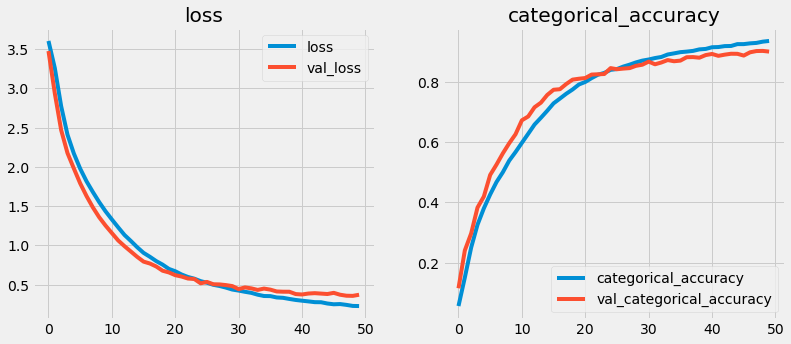

In [ ]:
plot_loss_accuracy(history)

In [ ]:
test_generator.reset()
score = model.evaluate_generator(test_generator, steps=test_generator.n // test_generator.batch_size)
print("Loss: {:6.2f}, Accuracy: {:6.2f}%".format(score[0],score[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss:   0.46, Accuracy:  88.96%


In [ ]:
test_generator.reset()
y_pred_raw = model.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size)

In [ ]:
data = (score,y_pred_raw)
file_to_store = open("/content/drive/MyDrive/Colab Notebooks/CV/overrall/original_model.p", "wb")
pickle.dump(data, file_to_store)
file_to_store.close()

In [ ]:
y_pred_raw.shape

(12630, 43)

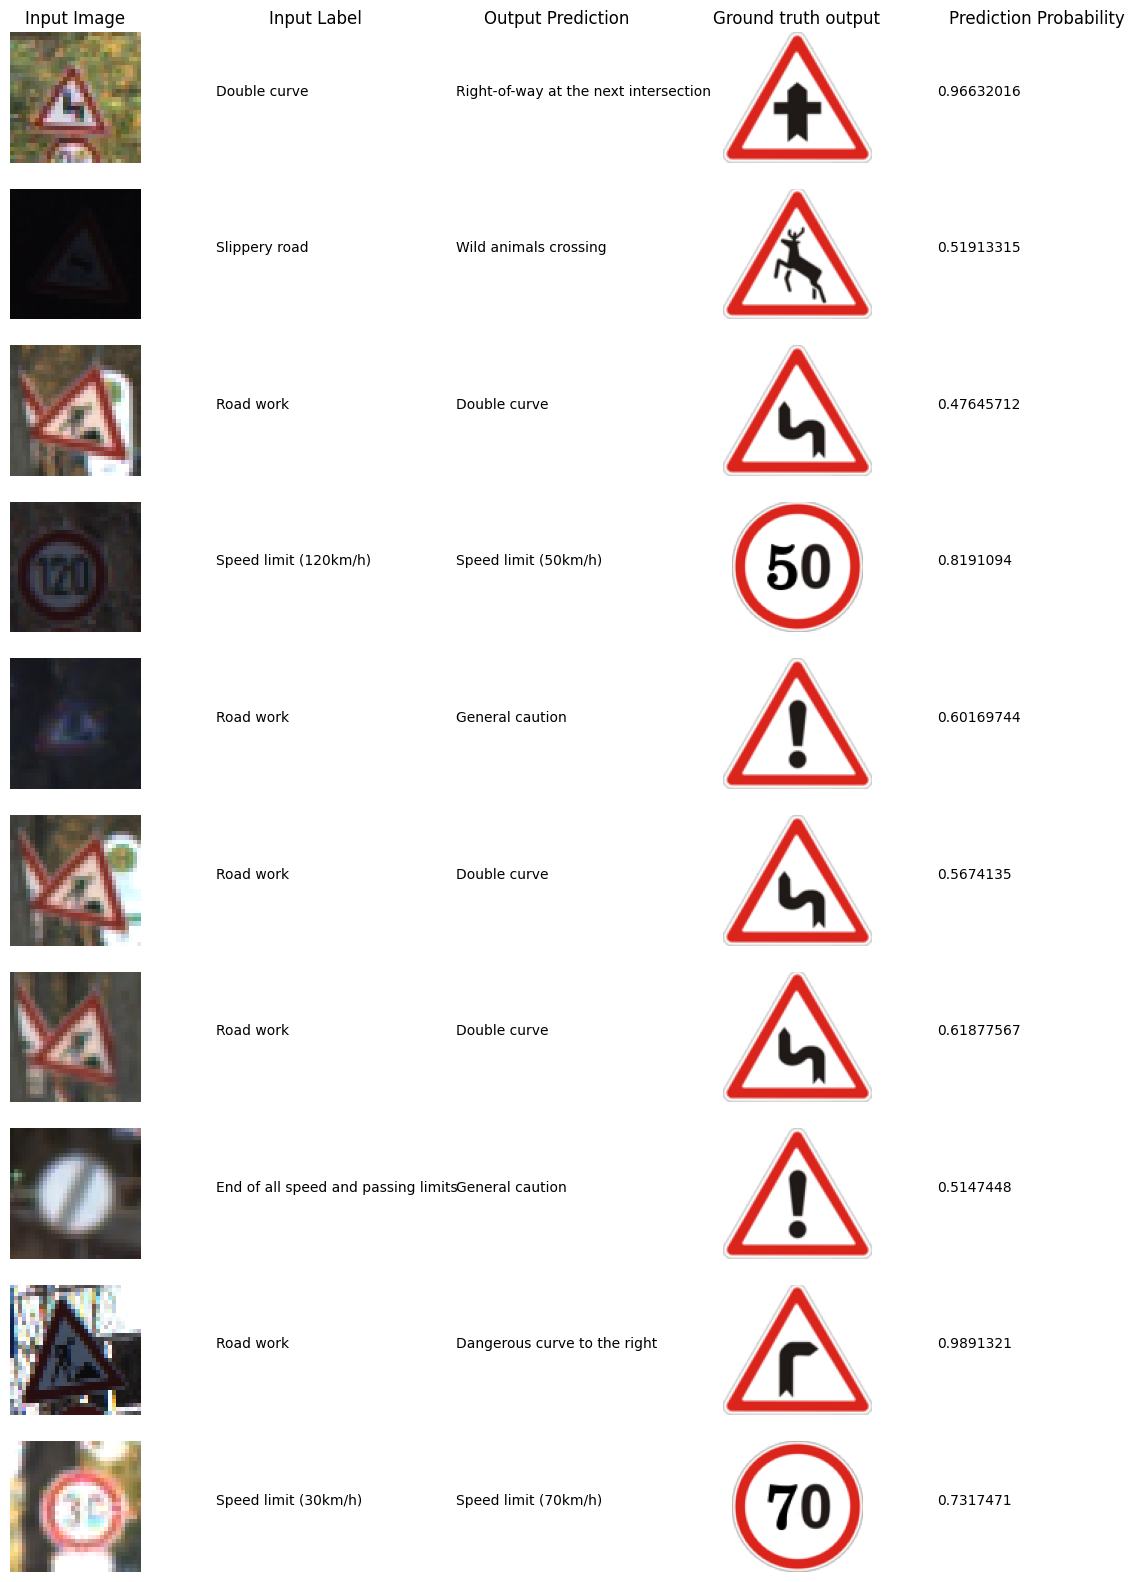

In [ ]:
plot_infer(10,X_test,y_test,y_pred_raw,False)

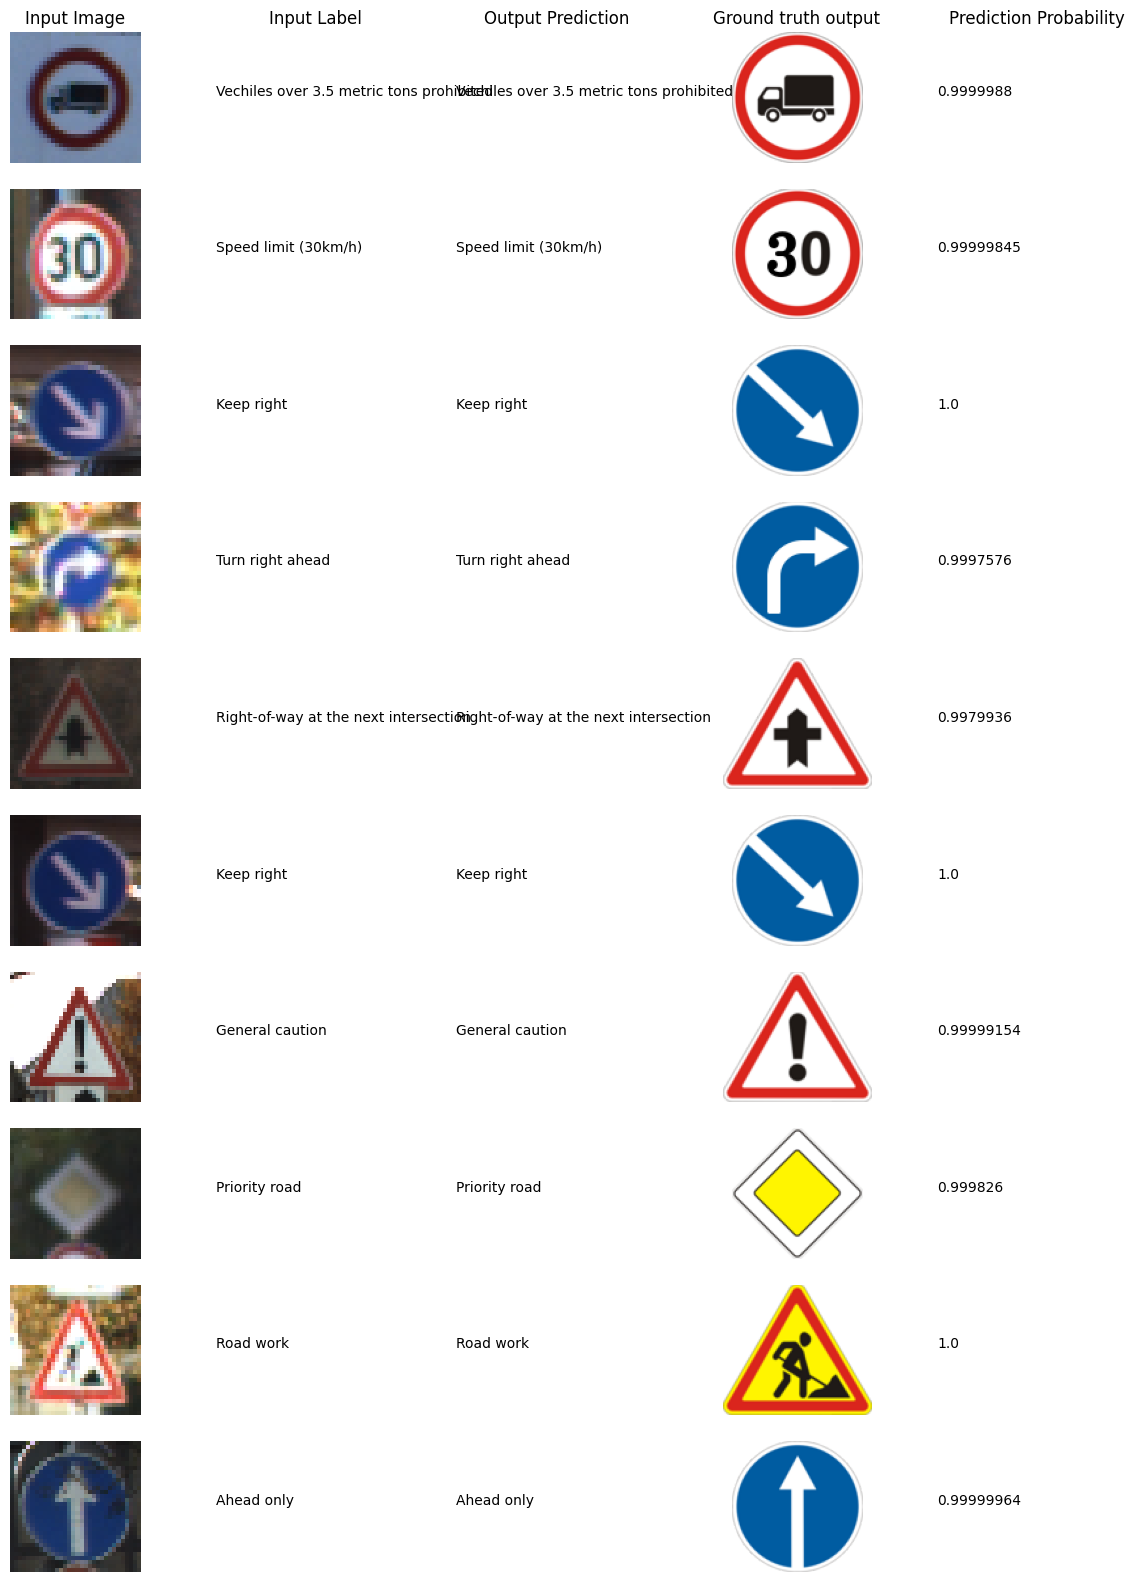

In [ ]:
plot_infer(10,X_test,y_test,y_pred_raw,True)

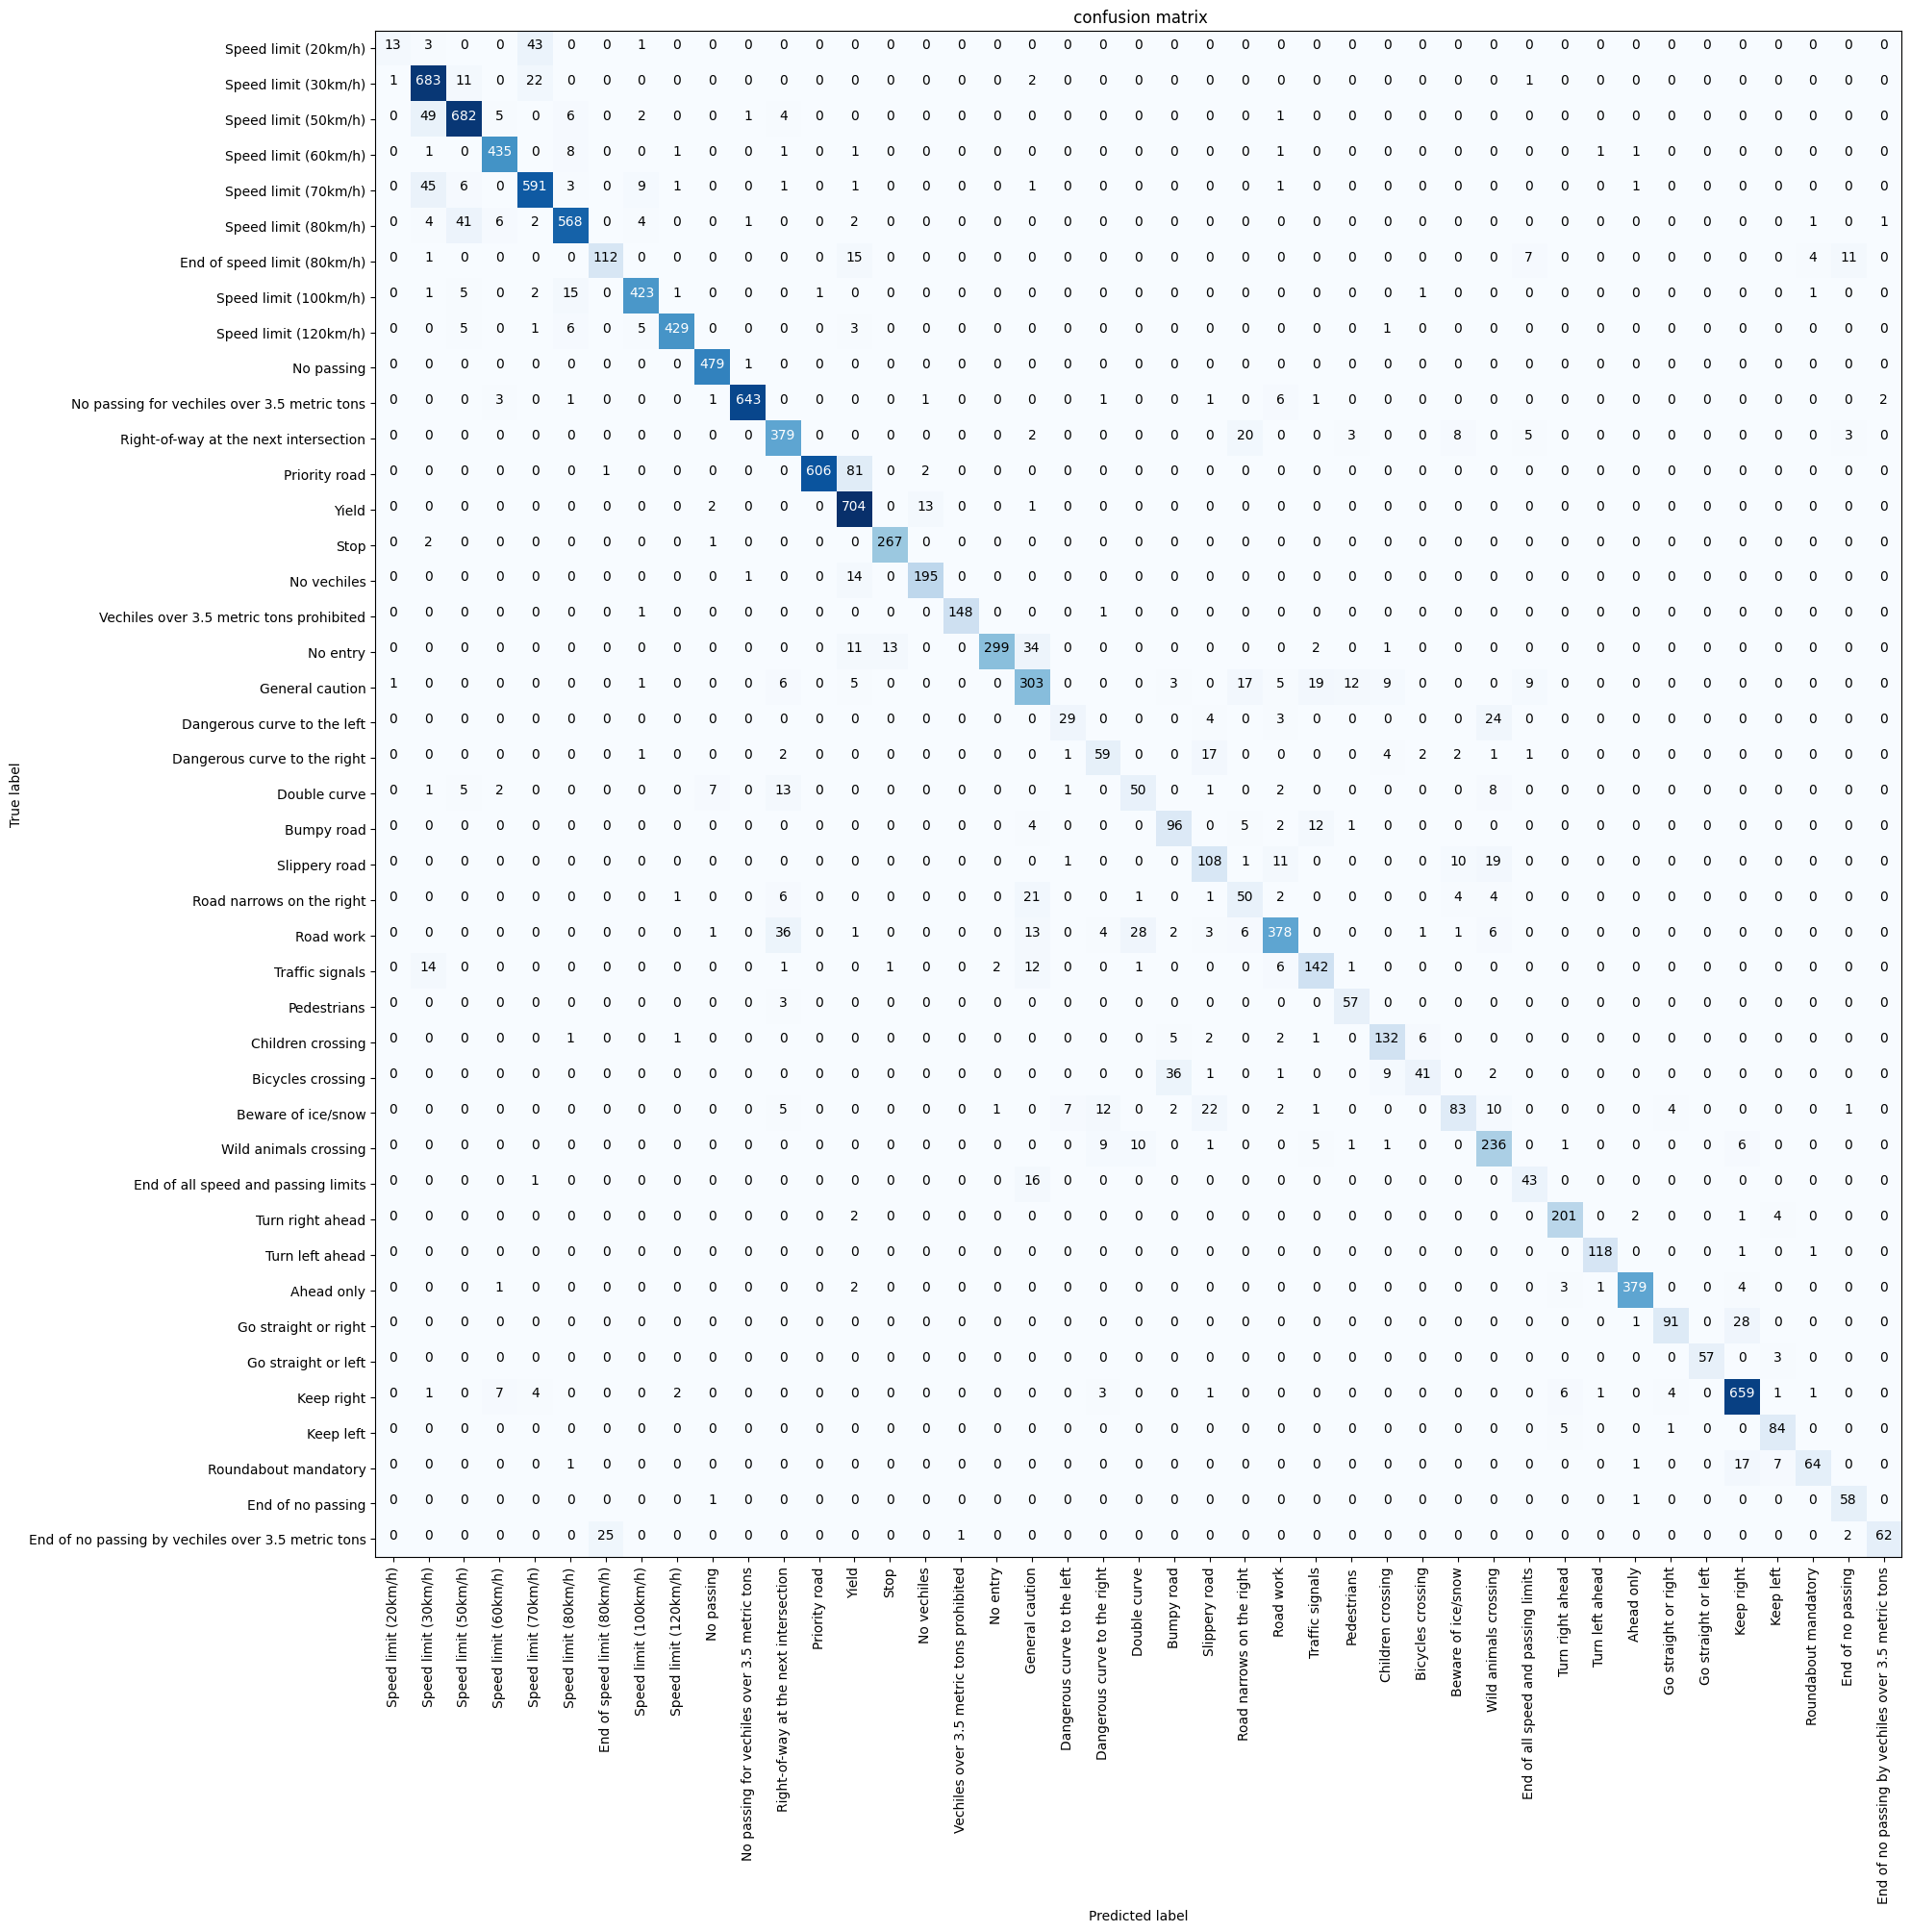

In [ ]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(get_cf(y_test,y_pred_raw), classes=g_labels, title=' confusion matrix')

In [ ]:
from sklearn import metrics

#Let's calculate precision & recall
precision = metrics.precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred_raw, axis=1), average=None)
recall = metrics.recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred_raw, axis=1), average=None)

print("Traffic Sign Label                                    Precision    Recall\n")
for i in range(len(g_labels)):
    print("{0:<50} {1:10.2f}% {2:10.2f}%".format(g_labels[i], precision[i]*100, recall[i]*100))

Traffic Sign Label                                    Precision    Recall

Speed limit (20km/h)                                    86.67%      21.67%
Speed limit (30km/h)                                    84.84%      94.86%
Speed limit (50km/h)                                    90.33%      90.93%
Speed limit (60km/h)                                    94.77%      96.67%
Speed limit (70km/h)                                    88.74%      89.55%
Speed limit (80km/h)                                    93.27%      90.16%
End of speed limit (80km/h)                             81.16%      74.67%
Speed limit (100km/h)                                   94.63%      94.00%
Speed limit (120km/h)                                   98.39%      95.33%
No passing                                              97.36%      99.79%
No passing for vechiles over 3.5 metric tons            99.38%      97.42%
Right-of-way at the next intersection                   82.93%      90.24%
Priority road            

## **8. Summary**